# Writing a simple forward model for ground-based spectroscopic observations
#### ESE156 2020,  5th notebook, Christian Frankenberg 

Here, we assume a spectrometer to be located on the ground, staring right into the sun, i.e. we have a direct light-path through the atmosphere. To generate a forward model, we need to:
<li> Read in an atmospheric profile of p/T and humidity
<li> Compute the dry vertical column density of each layer (and the water column)
<li> Define our trace gases of interest, specify a vertical profile (constant here for all but H2O)
<li> Compute the cross section of each gas for each atmospheric layer (function of p/T)
<li> Define a forward model that computes the transmission through the atmosphere (including trace gas absorptions), apply an instrument operator (convolution and resampling) and low-frequency multiplicator (Polynomial)
<li> Run the forward model and plot
<li> Add a solar transmission model to it
<li> Next steps: Define your "state vector" and think about how to compute the Jacobian


In [1]:
# Use our tools (you might need to add packages, see file)
include("ese156_tools.jl")

reduce_profile

---
#### Define file and lat/lon

In [2]:
file = "files/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? 
myLat = 34.1377;
myLon = -118.1253;

In [3]:
# Read profile (and generate dry/wet VCDs per layer)
profile_caltech_hr = read_atmos_profile(file, myLat, myLon, timeIndex);

---
#### Define HITRAN parameters

In [4]:
# Minimum wavenumber
ν_min  = 6100.0
# Maximum wavenumber
ν_xmax = 6400.0

co2_par = CrossSection.read_hitran("files/hitran_molec_id_2_CO2.par", mol=2, iso=1, ν_min=ν_min, ν_max=ν_xmax);
ch4_par = CrossSection.read_hitran("files/hitran_molec_id_6_CH4.par", mol=6, iso=1, ν_min=ν_min, ν_max=ν_xmax);
h2o_par = CrossSection.read_hitran("files/hitran_molec_id_1_H2O.par", mol=1, iso=1, ν_min=ν_min, ν_max=ν_xmax);

In [5]:
co2_voigt   = make_hitran_model(co2_par, Voigt(), wing_cutoff=10)
h2o_voigt   = make_hitran_model(h2o_par, Voigt(), wing_cutoff=10)
ch4_voigt   = make_hitran_model(ch4_par, Voigt(), wing_cutoff=10)

hitran_array = [co2_voigt, h2o_voigt, ch4_voigt];

---
#### Define model resolution and compute all cross sections for profile

In [6]:
res = 0.005
ν = 6300:res:6400
σ_matrix_hr = compute_profile_crossSections(profile_caltech_hr, hitran_array , ν);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


In [7]:
# Reduce dimensions, group layers together to get roughly layers of equal pressure difference:
n_layers = 15
profile_caltech, σ_matrix = reduce_profile(n_layers, profile_caltech_hr, σ_matrix_hr);

In [8]:
# Define concentration profile:
nL = length(profile_caltech.T)
vmr_co2 = zeros(nL) .+ 400e-6
vmr_ch4 = zeros(nL) .+ 2e-6
vmr_h2o = profile_caltech.vcd_h2o ./ profile_caltech.vcd_dry
vmrs = [vmr_co2, vmr_h2o, vmr_ch4 ];

# Define a polynomial scaling
p = Polynomial([2,-0.1,0.00003]);

Polynomial(2.0 - 0.1*x + 3.0e-5*x^2)

---
### Define Instrument models:

In [9]:
# Define an Instrument, TCCON specs
FWHM = 0.02  # 0.2cm-1 resolution
Δν = 0.01
tccon = KernelInstrument(gaussian_kernel(FWHM, res), collect(6300:Δν:6400));

# Define an Instrument, OCO-2 specs
FWHM = 0.4  # 0.2cm-1 resolution
Δν = 0.1
oco2 = KernelInstrument(gaussian_kernel(FWHM, res), collect(6300:Δν:6400));

# Define an Instrument, SCIAMACHY specs
FWHM = 4.0  # 0.2cm-1 resolution
Δν = 1.0
sciamachy = KernelInstrument(gaussian_kernel(FWHM, res), collect(6300:Δν:6400));

---
### Define a simplified Forward model:

In [10]:
function forward_model_tccon(vmrs,σ_matrix, profile, poly, sza; instrument, ν=ν)
    # Air Mass Factor
    AMF = 1/cosd(sza)
    
    # Total sum of τ
    ∑τ = zeros(size(σ_matrix,1))
    for i=1:length(vmrs)
        ∑τ[:] += sum(σ_matrix[:,:,i] .* (vmrs[i] .* profile.vcd_dry)', dims=2)
    end
    # Transmission
    T = exp.(-AMF * ∑τ)
    T_conv = conv_spectra(instrument, ν, T)
    # x-axis for polynomial [-1,1], enables legendre later:
    x_poly = rescale_x(instrument.ν_out)
    return T_conv .* poly.(x_poly)
end

forward_model_tccon (generic function with 1 method)

---
#### Compute F(x)
for different instruments

In [11]:
sza = 45.0  # Solar Zenith Angle
T_tccon     = forward_model_tccon(vmrs,σ_matrix, profile_caltech, p, sza; instrument=tccon );
T_oco2      = forward_model_tccon(vmrs,σ_matrix, profile_caltech, p, sza; instrument=oco2 );
T_sciamachy = forward_model_tccon(vmrs,σ_matrix, profile_caltech, p, sza; instrument=sciamachy );

--- 
#### Plot model output

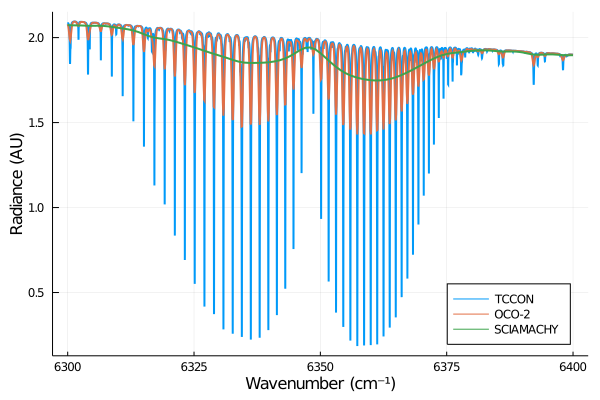

In [12]:
plot(tccon.ν_out,T_tccon, label="TCCON", legend=:bottomright, lw=2)
plot!(oco2.ν_out,T_oco2, label="OCO-2", lw=2)
plot!(sciamachy.ν_out,T_sciamachy, label="SCIAMACHY", lw=2)
xlabel!("Wavenumber (cm⁻¹)")
ylabel!("Radiance (AU)")

For fun, try to change some trace gas concentrations and see the change!

_____
The simple function above is an almost complete example of a forward model that can simulate an actual measurement. We can also write it in a way that we just need to provide a full state-vector $x$, which can include all trace gas VMRs as well as the polynomial and also a parameterization of the spectral sampling. SZA and FWHM would be external parameters that need to be provided but not fitted (but might have uncertainty themselves). 

There is one other thing that we forgot, namely Fraunhofer lines!

Similar to the atmospheric line transitions, there are databaases for solar absorption features. We now want to read  solar transmission spectrum (disk integrated vs. disk centered). A generated spectrum using a solar line-list (not a low resolution measured spectrum) can be downloaded at http://mark4sun.jpl.nasa.gov/toon/solar/solar_spectrum.html.

The solar transmission spectrum is basically calculated from a tabulated line-list (strength and width) compiled by Geoff Toon from JPL. These absorption features are caused by absorptions of trace elements in the solar photosphere.

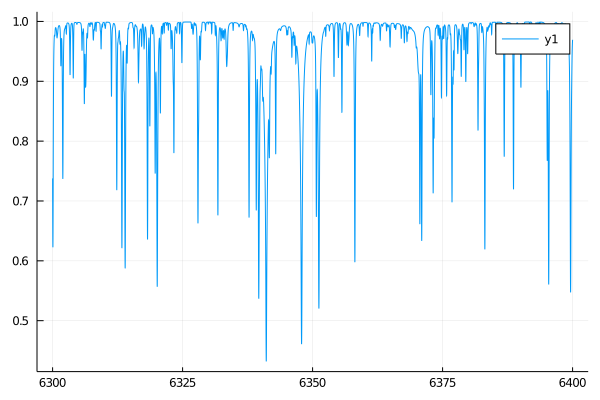

In [13]:
# Read in disk-centered solar spectrum:
sun = readdlm("files/solar_merged_20160127_600_26316_100.out")
f_solar = CubicSplineInterpolation(sun[1,1]:sun[2,1]-sun[1,1]:sun[end,1], sun[:,2])
Tsolar = f_solar(ν)

plot(ν, Tsolar)

In [14]:
# Add the sun to the forward model:
function forward_model_solar(vmrs,σ_matrix, profile, poly, sza; instrument, ν=ν, Tsolar=Tsolar)
    # Air Mass Factor
    AMF = 1/cosd(sza)
    
    # Total sum of τ
    ∑τ = zeros(size(σ_matrix,1))
    for i=1:length(vmrs)
        ∑τ[:] += sum(σ_matrix[:,:,i] .* (vmrs[i] .* profile.vcd_dry)', dims=2)
    end
    # Transmission
    T = Tsolar .* exp.(-AMF * ∑τ)
    T_conv = conv_spectra(instrument, ν, T)
    # x-axis for polynomial [-1,1], enables legendre later:
    x_poly = rescale_x(instrument.ν_out)
    return T_conv .* poly.(x_poly)
end

forward_model_solar (generic function with 1 method)

In [15]:
sza = 45.0
T_tccon_s     = forward_model_solar(vmrs,σ_matrix, profile_caltech, p, sza; instrument=tccon );
T_oco2_s      = forward_model_solar(vmrs,σ_matrix, profile_caltech, p, sza; instrument=oco2 );
T_sciamachy_s = forward_model_solar(vmrs,σ_matrix, profile_caltech, p, sza; instrument=sciamachy );

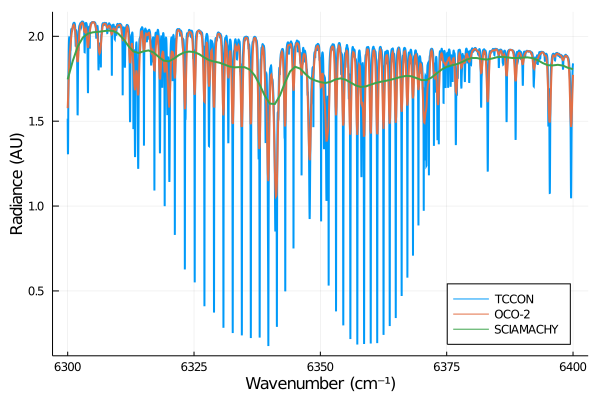

In [16]:
plot(tccon.ν_out,T_tccon_s, label="TCCON", legend=:bottomright, lw=2)
plot!(oco2.ν_out,T_oco2_s, label="OCO-2", lw=2)
plot!(sciamachy.ν_out,T_sciamachy_s, label="SCIAMACHY", lw=2)
xlabel!("Wavenumber (cm⁻¹)")
ylabel!("Radiance (AU)")

--- 
## How can we write this as a Forward Model F(x)?

First, we need to decide what we need in the state vector. If we assume that the temperature and pressure profile is well known, then these are "known" parameters and not part of the state vector. That probably leaves us with the polynomial term as well as the trace gas concentrations.

Julia has tools for automatic differentation (even though you should be able to do this specific one still analytically without too much effort). However, there are current programming constraints, it has to be defined as single-valued functions (f(x); x=1D array) and return a 1D array), so let's try:



In [17]:
# Let's concatenate the important parameters as state vector:
# Make ABSOLUTELY sure you keep the order as in the σ_matrix!!
𝐱 = [vmr_co2; vmr_h2o; vmr_ch4; p[:] ];
size(𝐱)

(48,)

In [18]:
# and then rewrite the forward model:
function forward_model_x(𝐱     ;instrument=tccon, sza=sza, profile=profile_caltech,σ_matrix=σ_matrix, ν=ν, Tsolar=Tsolar)
    FT = eltype(𝐱);
    dims = size(σ_matrix)
    vmrs = reshape(𝐱[1:(dims[2]*dims[3])],(dims[2],dims[3]) )
    poly = Polynomial(𝐱[dims[2]*dims[3]+1:end])
    
    # Air Mass Factor
    AMF = 1/cosd(sza)
    
    # Total sum of τ
    ∑τ = zeros(FT,size(σ_matrix,1))
    for i=1:size(vmrs,2)
        ∑τ[:] += sum(σ_matrix[:,:,i] .* (vmrs[:,i] .* profile.vcd_dry)', dims=2)
    end
    # Transmission
    T = Tsolar .* exp.(-AMF * ∑τ)
    T_conv = conv_spectra(instrument, ν, T)
    # x-axis for polynomial [-1,1], enables legendre later:
    x_poly = rescale_x(instrument.ν_out)
    return T_conv .* poly.(x_poly)
end

forward_model_x (generic function with 1 method)

In [19]:
# Predefine output
result = DiffResults.JacobianResult(zeros(length(tccon.ν_out)),𝐱);

In [25]:
# Not yet happy about the speed here, likely due to a ton of allocations
@time ForwardDiff.jacobian!(result, forward_model_x, 𝐱 );

  0.195063 seconds (726 allocations: 535.370 MiB, 35.66% gc time)


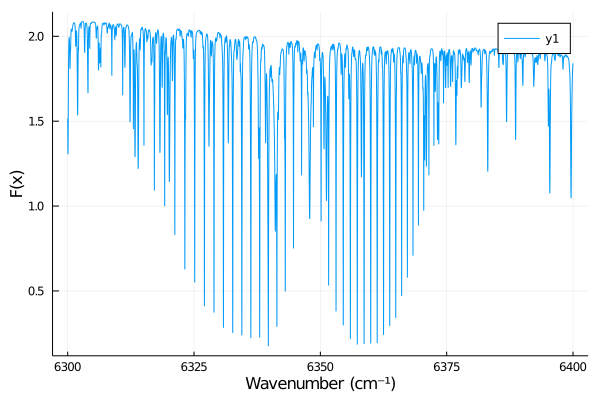

In [21]:
K = DiffResults.jacobian(result)
F = DiffResults.value(result)
plot(tccon.ν_out,F )
ylabel!("F(x)")
xlabel!("Wavenumber (cm⁻¹)")

In [33]:
ind = 1:n_layers
plot(tccon.ν_out,K[:,ind], label="CO2 Layer", alpha=0.5, lw=2 )
ylabel!("dF/dx")
xlabel!("Wavenumber (cm⁻¹)")
#xlims!(6322.8,6323.7)